In [8]:
from keras.preprocessing.image import img_to_array

In [9]:
# import the necessary packages
import cv2

class SimplePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        # store the target image width, height, and interpolation
        # method used when resizing
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        # resize the image to a fixed size, ignoring the aspect
        # ratio
        return cv2.resize(image, (self.width, self.height),interpolation=self.inter)

In [10]:
# import the necessary packages
from keras.preprocessing.image import img_to_array

class ImageToArrayPreprocessor:
    def __init__(self, dataFormat=None):
        # store the image data format
        self.dataFormat = dataFormat

    def preprocess(self, image):
        # apply the Keras utility function that correctly rearranges
        # the dimensions of the image
#         return img_to_array(image, data_format=self.dataFormat)
        return img_to_array(image)

In [11]:
# import the necessary packages
import numpy as np
import cv2
import os

class SimpleDatasetLoader:
#     def __init__(self, preprocessors=None):
    def __init__(self):

        from tqdm import tqdm

        # store the image preprocessor
#         self.preprocessors = preprocessors

        # if the preprocessors are None, initialize them as an
        # empty list
#         if self.preprocessors is None:
#             self.preprocessors = []

    def load(self, imagePaths, verbose=-1):
        # initialize the list of features and labels
        data = []
        labels = []
        
        from tqdm import tqdm
        i = 0
        for img in tqdm(os.listdir(imagePaths)):
            label = img
            path = os.path.join(imagePaths,img)
            for filename in os.listdir(path):
                image = cv2.imread(os.path.join(path, filename))
#                 print ('image = ', image)
#                 print ('os.path.join(path, filename) = ',os.path.join(path, filename))
#                 print ('filename = ', filename)
#                 if self.preprocessors is not None:
                    # loop over the preprocessors and apply each to
                    # the image
#                     for p in self.preprocessors:
                sp = SimplePreprocessor(32, 32)
                image = sp.preprocess(image)
#                 print ("sp completed")
                iap = ImageToArrayPreprocessor()
                image = iap.preprocess(image)

                # treat our processed image as a "feature vector"
                # by updating the data list followed by the labels
                data.append(image)
                labels.append(label)

#                         if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
#                             print("[INFO] processed {}/{}".format(i + 1,len(imagePaths)))

        #return a tuple of the data and labels
        return (np.array(data), np.array(labels))


In [22]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

class ShallowNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last"
		model = Sequential()
		inputShape = (height, width, depth)

		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)

		# define the first (and only) CONV => RELU layer
		model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
		model.add(Activation("relu"))

		# softmax classifier
		model.add(Flatten())
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [23]:
sp = SimplePreprocessor(32, 32)
iap = ImageToArrayPreprocessor()
sd1 = SimpleDatasetLoader()

In [13]:
imagePaths = 'G:/pyimagesearch/SB_Code/SB_Code/datasets/animals/'

In [14]:
(data, lables) = sd1.load(imagePaths, verbose=500)

100%|████████████████████████████████████████████████████████████| 3/3 [00:59<00:00, 19.20s/it]


In [15]:
data.shape

(3000, 32, 32, 3)

In [16]:
lables.shape

(3000,)

In [20]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from pyimagesearch.preprocessing import ImageToArrayPreprocessor
# from pyimagesearch.preprocessing import SimplePreprocessor
# from pyimagesearch.datasets import SimpleDatasetLoader
# from pyimagesearch.nn.conv import ShallowNet
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse

# construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", required=True,
# 	help="path to input dataset")
# args = vars(ap.parse_args())

# grab the list of images that we'll be describing
print("[INFO] loading images...")
# imagePaths = list(paths.list_images(args["dataset"]))
imagePaths = 'G:/pyimagesearch/SB_Code/SB_Code/datasets/animals/'
# initialize the image preprocessors
# sp = SimplePreprocessor(32, 32)
# iap = ImageToArrayPreprocessor()

# load the dataset from disk then scale the raw pixel intensities
# to the range [0, 1]
sdl = SimpleDatasetLoader()
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.astype("float") / 255.0



[INFO] loading images...


100%|████████████████████████████████████████████████████████████| 3/3 [01:59<00:00, 42.95s/it]


In [26]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, random_state=42)

# convert the labels from integers to vectors
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.005)
model = ShallowNet.build(width=32, height=32, depth=3, classes=3)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
	batch_size=32, epochs=2, verbose=1)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1),
	target_names=["cat", "dog", "panda"]))



[INFO] compiling model...
[INFO] training network...
Train on 2250 samples, validate on 750 samples
Epoch 1/2
2250/2250 [==============================] - ETA: 53s - loss: 1.1221 - acc: 0.25 - ETA: 30s - loss: 1.1115 - acc: 0.31 - ETA: 21s - loss: 1.1080 - acc: 0.33 - ETA: 17s - loss: 1.1036 - acc: 0.35 - ETA: 15s - loss: 1.1007 - acc: 0.36 - ETA: 13s - loss: 1.0933 - acc: 0.40 - ETA: 12s - loss: 1.0907 - acc: 0.40 - ETA: 10s - loss: 1.0853 - acc: 0.42 - ETA: 10s - loss: 1.0829 - acc: 0.42 - ETA: 9s - loss: 1.0893 - acc: 0.4188 - ETA: 8s - loss: 1.0891 - acc: 0.411 - ETA: 8s - loss: 1.0884 - acc: 0.408 - ETA: 7s - loss: 1.0854 - acc: 0.411 - ETA: 7s - loss: 1.0863 - acc: 0.399 - ETA: 7s - loss: 1.0854 - acc: 0.397 - ETA: 6s - loss: 1.0820 - acc: 0.410 - ETA: 6s - loss: 1.0816 - acc: 0.404 - ETA: 6s - loss: 1.0802 - acc: 0.413 - ETA: 5s - loss: 1.0806 - acc: 0.412 - ETA: 5s - loss: 1.0801 - acc: 0.407 - ETA: 5s - loss: 1.0785 - acc: 0.407 - ETA: 5s - loss: 1.0781 - acc: 0.411 - ETA: 5s 

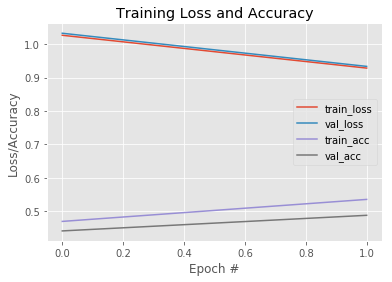

In [28]:
## plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 2), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 2), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 2), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 2), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()